In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, remove_self_loops
from torch_geometric.utils import softmax as edge_softmax
from torch_geometric.utils import to_networkx
from torch_scatter import scatter

# Link prediction

## 数据集

In [3]:
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
device = "cuda"
transform = T.Compose(
    [
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(num_test=0.2, num_val=0, add_negative_train_samples=True),
    ]
)
dataset = Planetoid(root="./data/Planetoid", name="CiteSeer", transform=transform)

print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


不拆
- Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


拆但是不加负边
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[7284], edge_label_index=[2, 7284])
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])
- Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])


拆且加负边
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[14568], edge_label_index=[2, 14568])
- Data(x=[3327, 3703], edge_index=[2, 7284], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])
- Data(x=[3327, 3703], edge_index=[2, 8194], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], edge_label=[1820], edge_label_index=[2, 1820])




edge_label=1/0 表示正边和负边<br>
edge_index 是原始图的边<br>
edge_label_index 是加上负边之后的边<br>

```python
positive edge:
 tensor([[1422,  205,   27,  ...,   83, 2126, 1558],
        [2181,  783,  755,  ...,  584,  626, 2331]])
        
negative edge:
 tensor([[ 450, 1854, 3065,  ..., 2952,  529, 1468],
        [1263, 2073,  909,  ...,  502, 1698, 3210]])
```

In [4]:
train_data, val_data, test_data = dataset[0]

## SAGEConv

In [5]:
class mySAGEConv(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super(mySAGEConv, self).__init__(aggr="mean")
        self.W = nn.Linear(2 * in_feats, out_feats, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W.weight)

    def forward(self, x, edge_index):
        hN = self.propagate(edge_index, x=x)
        h_cat = torch.cat([x, hN], dim=1)

        h = self.W(h_cat)
        h = F.normalize(h, dim=1)
        return h

    def message(self, x_j, edge_index):
        return x_j

## SAGE_LP

In [6]:
class SAGE_LP(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super(SAGE_LP, self).__init__()
        self.conv1 = mySAGEConv(in_feats, hid_feats)
        self.conv2 = mySAGEConv(hid_feats, out_feats)

        self.lin1 = nn.Linear(out_feats * 2, out_feats)
        self.lin2 = nn.Linear(out_feats, 1)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)

    def encode(self, x, edge_index):
        # encode 使用edge_index，使用原图的连接信息
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, h, edge_label_index):
        # decode，使用edge_label_index，带有正负边的信息
        src = h[edge_label_index[0]]
        dst = h[edge_label_index[1]]

        h = self.lin1(torch.cat([src, dst], dim=1)).relu()
        h = self.lin2(h)
        return h

    def forward(self, x, edge_index, edge_label_index):
        h = self.encode(x, edge_index)
        return self.decode(h, edge_label_index)

## 训练和测试

In [21]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)


def test(data):
    with torch.no_grad():
        model.eval()
        logits = model.forward(data.x, data.edge_index, data.edge_label_index).cpu()
        labels = data.edge_label.int().cpu()

        pred = logits > 0

        acc = accuracy_score(pred, labels)
        f1 = f1_score(pred, labels)
        auc = roc_auc_score(labels, logits)

        return acc, f1, auc


def train():
    model.train()
    optimizer.zero_grad()
    logits = model(
        train_data.x, train_data.edge_index, train_data.edge_label_index
    ).squeeze()
    labels = train_data.edge_label

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
in_feats = train_data.num_features
hid_feats = 128
out_feats = 64

model = SAGE_LP(in_feats, hid_feats, out_feats).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = F.binary_cross_entropy_with_logits

In [13]:
for e in range(101):
    loss = train()

    if e % 10 == 0:
        # print(f"epoch {e}, loss: {loss:.6f}, AUC: {test():.6f}")
        print(f"epoch {e}, loss: {loss:.6f}")

epoch 0, loss: 0.693185
epoch 10, loss: 0.456254
epoch 20, loss: 0.268845
epoch 30, loss: 0.126901
epoch 40, loss: 0.050405
epoch 50, loss: 0.019919
epoch 60, loss: 0.009175
epoch 70, loss: 0.005214
epoch 80, loss: 0.003485
epoch 90, loss: 0.002584
epoch 100, loss: 0.002045


In [22]:
print("train: acc, f1, auc: ", test(train_data))

train: acc, f1, auc:  (1.0, 1.0, 1.0)


In [23]:
print("train: acc, f1, auc: ", test(test_data))

train: acc, f1, auc:  (0.7175824175824176, 0.7110736368746486, 0.7773101074749427)


# Graph prediction

## 数据集

In [16]:
import torch_geometric.transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures

device = "cuda"
transform = T.Compose([T.ToDevice(device)])
dataset = TUDataset(root="./data/TUDataset", name="MUTAG", transform=transform)

In [17]:
print(dataset)
print("n of classes:", dataset.num_classes)
print("n of graphs", len(dataset))
print("n of feature", dataset.num_features)

MUTAG(188)
n of classes: 2
n of graphs 188
n of feature 7


In [26]:
# 打乱
dataset.shuffle()

num_train = int(len(dataset) * 0.8)
train_dataset = dataset[:num_train]
test_dataset = dataset[num_train:]

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of test graphs: {len(test_dataset)}")

Number of training graphs: 150
Number of test graphs: 38


In [62]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


for step, data_batch in enumerate(train_loader):
    print(f"Step {step + 1}:")
    print("=======")
    print(f"Number of graphs in the current batch: {data_batch.num_graphs}")
    print(data_batch)
    print()
    break

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2578], x=[1165, 7], edge_attr=[2578, 4], y=[64], batch=[1165], ptr=[65])



Dataloader中，每次迭代取到data_batch,data_bach.batch用于区分哪些点属于同一幅图

## GATConv

In [80]:
class myGATConv(MessagePassing):
    def __init__(self, in_feats, out_feats, edge_dim):
        super(myGATConv, self).__init__()
        self.w_node = nn.Linear(in_feats, out_feats, bias=False)
        self.w_edge = nn.Linear(edge_dim, out_feats, bias=False)

        self.a_self = nn.Linear(out_feats, 1, bias=False)
        self.a_neih = nn.Linear(out_feats, 1, bias=False)
        self.a_edge = nn.Linear(out_feats, 1, bias=False)
        self.edge_dim = edge_dim

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.w_node.weight)
        torch.nn.init.xavier_uniform_(self.w_edge.weight)
        torch.nn.init.xavier_uniform_(self.a_self.weight)
        torch.nn.init.xavier_uniform_(self.a_neih.weight)
        torch.nn.init.xavier_uniform_(self.a_edge.weight)

    def forward(self, x, edge_index, edge_attr, get_attention=False):
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        edge_index, edge_attr = add_self_loops(
            edge_index, edge_attr, num_nodes=x.shape[0], fill_value="mean"
        )

        edge_attr = edge_attr.view(-1, self.edge_dim)

        wx = self.w_node(x)
        we = self.w_edge(edge_attr)
        alpha = self.edge_updater(edge_index, we=we, wx=wx)
        out = self.propagate(edge_index, wx=wx, alpha=alpha)

        if get_attention:
            return out, alpha
        else:
            return out

    def message(self, wx_j, alpha):
        return alpha * wx_j

    def edge_update(self, edge_index, wx_i, wx_j, we):
        e = self.a_neih(wx_j) + self.a_self(wx_i) + self.a_edge(we)
        e = F.leaky_relu(e)
        alpha = edge_softmax(e, edge_index[1])
        return alpha

## GAT

In [81]:
edge_dim = dataset.num_edge_features
in_feats = dataset.num_node_features
out_feats = dataset.num_classes

In [101]:
from torch_geometric.nn import global_mean_pool


class GAT(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, edge_dim):
        super(GAT, self).__init__()
        self.conv1 = myGATConv(in_feats, hid_feats, edge_dim)
        self.conv2 = myGATConv(hid_feats, hid_feats, edge_dim)
        self.lin = nn.Linear(hid_feats, out_feats)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, training=self.training)
        x = self.lin(x)
        return x

In [127]:
model = GAT(in_feats, 32, out_feats, edge_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [128]:
def train():
    model.train()
    for data_batch in train_loader:
        optimizer.zero_grad()
        logits = model(
            data_batch.x, data_batch.edge_index, data_batch.edge_attr, data_batch.batch
        )
        loss = criterion(logits, data_batch.y)
        loss.backward()
        optimizer.step()
    return loss


def test(loader):
    model.eval()
    correct = 0
    for data_batch in loader:
        with torch.no_grad():
            pred = model(
                data_batch.x,
                data_batch.edge_index,
                data_batch.edge_attr,
                data_batch.batch,
            ).argmax(dim=1)
            correct+=(pred==data_batch.y).sum().item()

    return correct / len(loader.dataset)
        


In [129]:
train_accs = []
test_accs = []
for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 010, Train Acc: 0.7800, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.7333, Test Acc: 0.7632
Epoch: 030, Train Acc: 0.7533, Test Acc: 0.7895
Epoch: 040, Train Acc: 0.7933, Test Acc: 0.7105
Epoch: 050, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 060, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 070, Train Acc: 0.8067, Test Acc: 0.7632
Epoch: 080, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 090, Train Acc: 0.7933, Test Acc: 0.7632
Epoch: 100, Train Acc: 0.8000, Test Acc: 0.7632
Epoch: 110, Train Acc: 0.7933, Test Acc: 0.7895
Epoch: 120, Train Acc: 0.7733, Test Acc: 0.7632
Epoch: 130, Train Acc: 0.7867, Test Acc: 0.7105
Epoch: 140, Train Acc: 0.7867, Test Acc: 0.7368
Epoch: 150, Train Acc: 0.8000, Test Acc: 0.7368
Epoch: 160, Train Acc: 0.7933, Test Acc: 0.7105
Epoch: 170, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 180, Train Acc: 0.8133, Test Acc: 0.7632
Epoch: 190, Train Acc: 0.7867, Test Acc: 0.7368
Epoch: 200, Train Acc: 0.8133, Test Acc: 0.7368


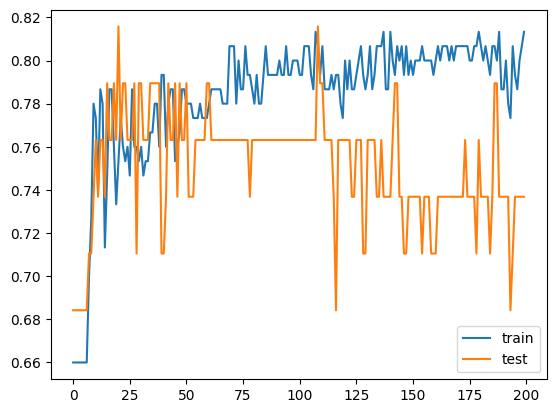

In [130]:
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.legend()
plt.show()